In [1]:
import pandas as pd
import numpy as np
from datetime import date

In [2]:
# import sys
# sys.path.append('.../Jane')

import extract_data_ez
import transformers_ez

%load_ext autoreload
%autoreload 2

Your data is ready! Merged table name is zillow_full.


In [3]:
zillow_full_initial = extract_data_ez.zillow_full
zillow_full_initial = pd.read_csv('zillow_full_imputed.csv')

In [4]:
df = zillow_full_initial.copy()
df.set_index('Date',inplace = True)
#df = transformers_ez.impute_by_county(df,colname,method)

In [5]:
df.head()

,Zipcode,City,State,Metro,County,SizeRank,Rent,Year,State-County,AQIMean,...,pct_poverty,housing_availability,home_density,pct_employed,pct_jobs_nightlife,pct_unemployed,move_within_city,move_new_city,avg_commute_time,pct_college
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3566.0,2015,NY-New York County,21.963579,...,0.145510,1.153877,2.214388,0.932888,0.088021,0.066820,0.084888,0.051420,30.096886,0.216281
2015-01-01,10023,New York,NY,New York-Newark-Jersey City,New York County,3,3413.0,2015,NY-New York County,21.963579,...,0.082199,1.231472,1.853056,0.955315,0.082397,0.044685,0.073276,0.039193,27.057535,0.262305
2015-01-01,10002,New York,NY,New York-Newark-Jersey City,New York County,7,3508.0,2015,NY-New York County,21.963579,...,0.276575,1.065116,2.235927,0.929920,0.168466,0.070080,0.051605,0.018042,30.594358,0.172389
2015-01-01,11226,New York,NY,New York-Newark-Jersey City,Kings County,11,1876.0,2015,NY-Kings County,21.963579,...,0.174138,1.097732,2.729889,0.928099,0.103083,0.071901,0.045075,0.010311,42.388151,0.127736
2015-01-01,10467,New York,NY,New York-Newark-Jersey City,Bronx County,12,1442.0,2015,NY-Bronx County,22.977550,...,0.278866,1.048949,2.824023,0.874915,0.129880,0.125085,0.093202,0.008001,43.596975,0.086000


In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [7]:
LE = LabelEncoder()
ss = StandardScaler()
features = df.drop(['Rent','State-County','State'],axis = 1)
y = np.log(df['Rent'])

In [8]:
from sklearn.compose import ColumnTransformer

features['Zipcode'] = features['Zipcode'].astype(int)

In [9]:
cat_cols = features.select_dtypes(include = object).copy()
num_cols = features.select_dtypes(exclude = object).copy()

In [10]:
for col in cat_cols.columns:
    cat_cols[col] = LE.fit_transform(cat_cols[col])

X = pd.concat([cat_cols,num_cols],axis = 1)

In [11]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor()

In [12]:
Xtrain = X.loc[X.index <'2019-01-01']
train_index = Xtrain.shape[0]
Xtest = X[train_index:]
ytrain = y[:train_index]
ytest = y[train_index:]

In [13]:
rfc.fit(Xtrain,ytrain)

RandomForestRegressor()

In [14]:
rfc.score(Xtrain,ytrain)

0.9995545697001116

In [15]:
rfc.score(Xtest,ytest)

0.983425176622079

In [16]:
rfc.feature_importances_

array([0.00194178, 0.39315284, 0.00513986, 0.07809211, 0.00532034,
       0.00818233, 0.00151065, 0.00660223, 0.00507773, 0.00136261,
       0.00398203, 0.00114274, 0.00367977, 0.00832202, 0.14600762,
       0.0311183 , 0.00500884, 0.05927257, 0.00347627, 0.00228104,
       0.00896598, 0.00255963, 0.00273065, 0.01001071, 0.19807256,
       0.00698678])

In [17]:
rfc_imp = pd.DataFrame({'Columns':X.columns,'Feature_importances':rfc.feature_importances_})

In [18]:
rfc_imp = rfc_imp.sort_values(by = 'Feature_importances',ascending = False)

In [19]:
rfc_imp

,Columns,Feature_importances
1,Metro,0.393153
24,avg_commute_time,0.198073
14,income_per_capita,0.146008
3,Zipcode,0.078092
17,housing_availability,0.059273
15,gini_index,0.031118
23,move_new_city,0.010011
20,pct_jobs_nightlife,0.008966
13,median_income,0.008322
5,Year,0.008182


In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

<AxesSubplot:xlabel='Columns', ylabel='Feature_importances'>

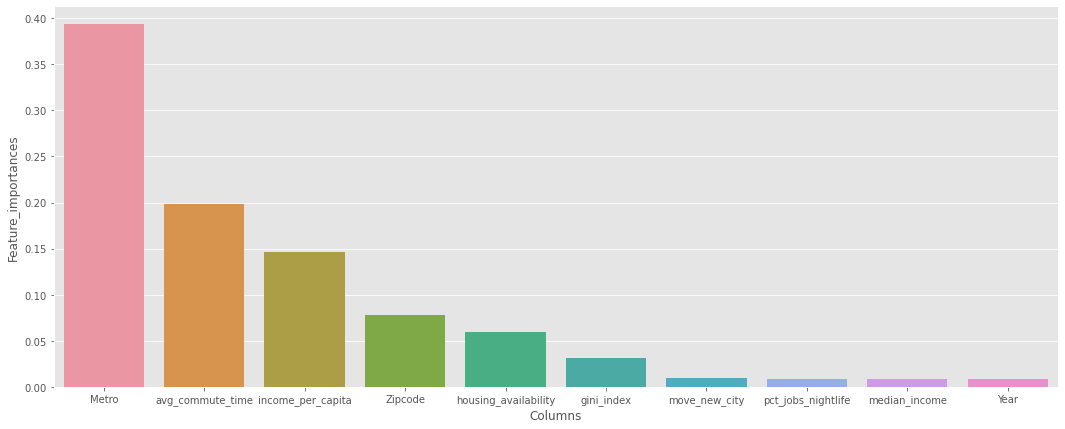

In [21]:
plt.figure(figsize=(18,7))
sns.barplot(x='Columns', y='Feature_importances', data=rfc_imp[:10])

In [53]:
new_df = zillow_full_initial.copy()
new_df['Date'] = pd.to_datetime(new_df['Date'])
group_cols = ['Date','State']
metrics = ['Rent']
mean_df = new_df[group_cols+metrics].groupby(group_cols).mean().reset_index()
mean_df['calc_type'] = 'mean'
max_df = new_df[group_cols+metrics].groupby(group_cols).max().reset_index()
max_df['calc_type'] = 'max'
min_df = new_df[group_cols+metrics].groupby(group_cols).min().reset_index()
min_df['calc_type'] = 'min'

combined = pd.concat([max_df,min_df,mean_df])

In [54]:
combined.head()

,Date,State,Rent,calc_type
0,2015-01-01,CA,3899.0,max
1,2015-01-01,FL,2282.0,max
2,2015-01-01,NY,4733.0,max
3,2015-01-01,TX,1903.0,max
4,2015-02-01,CA,3918.0,max


In [55]:
# plt.figure(figsize=(18,7))
# sns.lineplot(x='Date', y='Rent', data=combined,hue='calc_type')

In [56]:
def plot_custom(mean_df,max_df,min_df, state):
    city_map = {'CA':'San Francisco','TX':'Austin','NY':'New York City','FL':'Miami'}
    plt.plot( 'Date', 'Rent', data=mean_df[mean_df['State']==state], markersize=12, color='skyblue', label="Mean Rent", linewidth=1)
    plt.plot( 'Date', 'Rent', data=max_df[max_df['State']==state], markersize=12, color='red', label="Max Rent", linewidth=1)
    plt.plot( 'Date', 'Rent', data=min_df[min_df['State']==state], markersize=12, color='green', label="Min Rent", linewidth=1)
    plt.xlabel("Date")
    plt.ylabel("Rent")
    plt.title(city_map[state])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

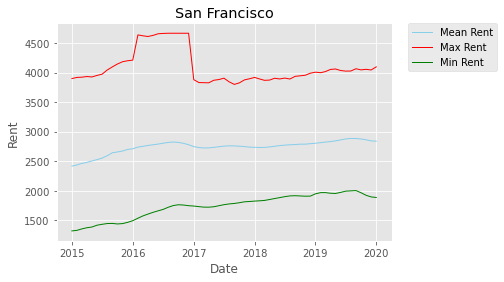

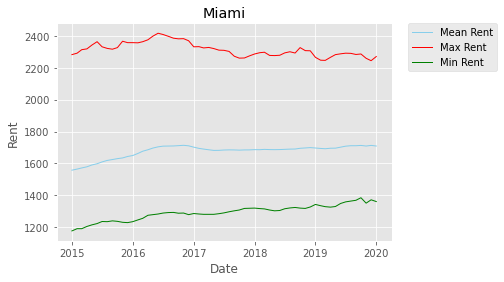

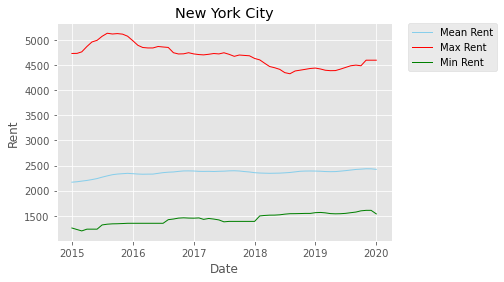

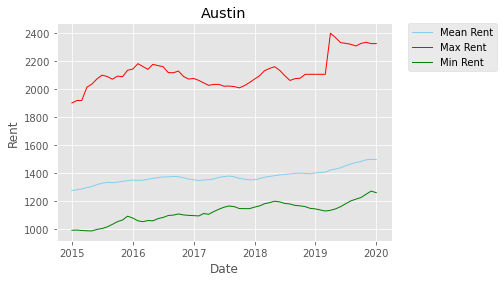

In [57]:
for state in max_df['State'].unique():
    fig, axs = plt.subplots(1)
    plot_custom(mean_df,max_df,min_df, state)

In [27]:
df = zillow_full_initial.copy()
df = df[['Date','Rent','Zipcode']]
min_month = df['Date'].min()
max_month = df['Date'].max()

min_df = df[df['Date']==min_month]
min_df = min_df.rename(columns={'Rent':'Rent_Start'})
max_df = df[df['Date']==max_month]
max_df = max_df.rename(columns={'Rent':'Rent_End'})
diff_df = pd.merge(min_df,max_df,on=['Zipcode'],how='inner')

In [28]:
diff_df['rent_diff'] = diff_df['Rent_End'] - diff_df['Rent_Start']
diff_df = diff_df.sort_values(['rent_diff'],ascending=False)

In [29]:
extreme_df = pd.concat([diff_df[:5],diff_df[-5:]])
extreme_zips = extreme_df['Zipcode'].unique().tolist()

In [30]:
df = zillow_full_initial.copy()
df = df[df['Zipcode'].isin(extreme_zips)]

<AxesSubplot:xlabel='Date', ylabel='Rent'>

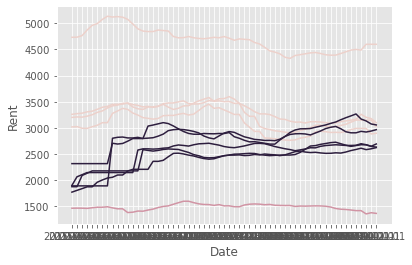

In [31]:
sns.lineplot(data=df, x="Date", y="Rent",hue='Zipcode',legend=None)

In [32]:
df = zillow_full_initial.copy()
df = df[['Date','Rent','State','Zipcode']]
min_month = df['Date'].min()
max_month = df['Date'].max()

min_df = df[df['Date']==min_month]
min_df = min_df.rename(columns={'Rent':'Rent_Start'})
max_df = df[df['Date']==max_month]
max_df = max_df.rename(columns={'Rent':'Rent_End'})

del max_df['Date']
del min_df['Date']
diff_df = pd.merge(min_df,max_df,on=['State','Zipcode'],how='inner')
diff_df['rent_diff'] = diff_df['Rent_End'] - diff_df['Rent_Start']
diff_df = diff_df.sort_values(['rent_diff'],ascending=False)

In [33]:
min_zips = []
max_zips = []

for state in diff_df['State'].unique():
    temp = diff_df.copy()
    temp = temp[temp['State']==state]
    max_zips.append(temp[:1]['Zipcode'].min())
    min_zips.append(temp[-1:]['Zipcode'].min())

In [58]:
df = zillow_full_initial.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Zipcode'].isin(max_zips)]
color_map = {'NY': 'red', 'FL': 'green', 'CA': 'blue', 'TX': 'black'}
df['color'] = df['State'].apply(lambda x: color_map[x])

In [59]:
color_dict = dict(zip(df.Zipcode, df.color))

In [60]:
state_zip_dict = dict(zip(df.Zipcode, df.State))

In [61]:
state_zip_dict

{33308: 'FL', 94014: 'CA', 10305: 'NY', 78701: 'TX'}

In [64]:
# test = df.copy()
# test = test[test['Date']=='2015-01-01']
# test

Text(0.5, 1.0, 'Largest Rent Increases')

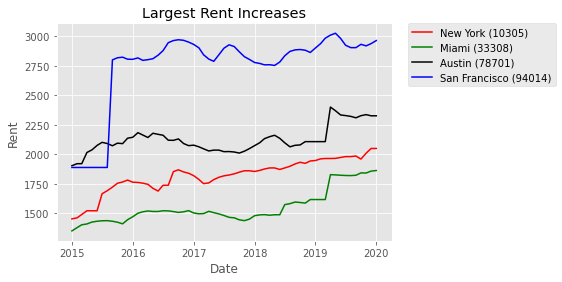

In [62]:
fig = sns.lineplot(data=df, x="Date", y="Rent",hue='Zipcode',legend=True,palette=color_dict)
#plt.legend(labels=['NY', 'FL','CA','TX'],labelcolor=['red','green','blue','black'])
fig.legend(['New York (10305)','Miami (33308)','Austin (78701)','San Francisco (94014)'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.set_title('Largest Rent Increases')

In [67]:
df = zillow_full_initial.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Zipcode'].isin(min_zips)]
color_map = {'NY': 'red', 'FL': 'green', 'CA': 'blue', 'TX': 'black'}
df['color'] = df['State'].apply(lambda x: color_map[x])

In [68]:
color_dict = dict(zip(df.Zipcode, df.color))

In [69]:
state_zip_dict = dict(zip(df.Zipcode, df.State))

In [70]:
state_zip_dict

{10028: 'NY', 95134: 'CA', 33460: 'FL', 78751: 'TX'}

Text(0.5, 1.0, 'Largest Rent Decreases (Or Smallest Increase)')

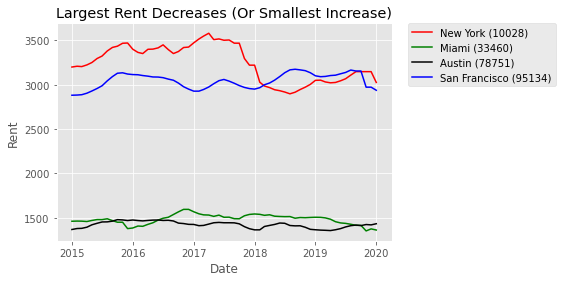

In [71]:
fig.set_title('Largest Rent Decreases (Or Smallest Increase)')

fig = sns.lineplot(data=df, x="Date", y="Rent",hue='Zipcode',legend=True,palette=color_dict)
#plt.legend(labels=['NY', 'FL','CA','TX'],labelcolor=['red','green','blue','black'])
fig.legend(['New York (10028)','Miami (33460)','Austin (78751)','San Francisco (95134)'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.set_title('Largest Rent Decreases (Or Smallest Increase)')
#fig.set_xticklabels(['2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01'])

In [73]:
# test = df.copy()
# test = test[test['Date']=='2015-01-01']
# test